# Chapter 15. RNN과 CNN을 사용해 시퀀스 처리하기

# 기본 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

이 장에서는 미래를 어느 정도 예측할 수 있는 네트워크인 **순환 신경망(recurrent neural networks, RNN)**을 알아볼 것임

# 15.1 순환 뉴런과 순환 층

지금까지 알아본 신경망은 활성화 신호가 입력층에서 출력층 한 방향으로만 흐르는 **피드포워드 신경망**이었음  
RNN은 피드포워드 신경망과 매우 비슷하지만 **뒤쪽으로 순환하는 연결도 있다는 점**이 다름!  

## 15.1.1 메모리 셀

**메모리 셀(memory cell)**: 타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소  
타임 스텝 t에서 순환 뉴런의 출력은 <u> 이전 타임 스텝의 모든 입력에 대한 함수</u>이므로 이를 일종의 **메모리** 형태라고 할 수 있음  

## 15.1.2 입력과 출력 시퀀스

- **시퀀스-투-시퀀스 네트워크**: 입력 시퀀스를 받아 출력 시퀀스를 만들어내는 네트워크  
ex. 주식가격 같은 시계열 데이터 예측에 주로 사용
- **시퀀스-투-벡터 네트워크**: 입력 시퀀스를 네트워크에 주입하고 마지막 셀에서만 출력을 만들어내는 네트워크  
ex. 영화 리뷰에 있는 연속된 단어를 주입하면 최종 감성 점수를 출력하는 경우  
- **벡터-투-시퀀스 네트워크**: 각 타임 스텝에서 하나의 입력 벡터를 반복해서 네트워크에 주입하여 출력 시퀀스를 만들어내는 네트워크  
ex. 이미지(or CNN의 출력)를 입력하여 이미지에 대한 캡션을 출력하는 경우  
- **인코더-디코더**: 시퀀스-투-벡터 네트워크(인코더) 뒤에 벡터-투-시퀀스 네트워크(디코더)를 연결한 네트워크  
ex. 한 언어의 문장을 다른 언어의 문장으로 번역하는 경우  
<img src="https://drive.google.com/uc?id=1kEe-6CNjUPON6zwV0ODfZwfKddOP3R48" height=400, width=600>

# 15.2 RNN 훈련하기

**BPTT(BackPropagation Through Time)**: RNN을 훈련하기 위한 기법, 타임 스텝으로 네트워크를 펼치고 보통의 역전파를 이용하는 전략  
<img src="https://drive.google.com/uc?id=1gXKWgTHKNtP3OsJs-glIBY1UA8Q5fANK" height=300, width=600>  

- 위 그림에서 흐린 파선: 정방향 패스  
- 위 그림에서 진한 실선: 비용 함수의 그레이디언트가 역방향으로 전파되는 모습

# 15.3 시계열 예측하기

<용어 정리>  
- 시계열(time series): 타임 스텝마다 하나 이상의 값을 가진 시퀀스
- 단변량(univariate) 시계열: 타임 스텝마다 하나의 값을 가지는 시퀀스
- 다변량(multivariate) 시계열: 타임 스텝마다 여러 값을 가지는 시퀀스
- forecasting: 예측, 즉 미래의 값을 예측하는 것
- imputation: 값 대체, 과거 데이터에서 누락된 값을 예측하는 것

### 데이터셋 생성
`generate_time_series()` 함수로 생성한 시계열을 사용:

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # 웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

# train, valid, test 데이터 생성
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


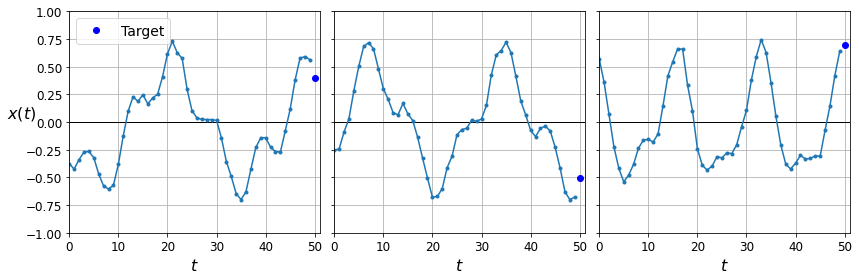

In [5]:
# 시계열 데이터 그래프 작성해주는 함수
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps+1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col==0))
save_fig("time_series_plot")
plt.show()

## 15.3.1 기준 성능

RNN을 시작하기 전에 기준 성능을 몇 개 준비하는 것이 좋음(그렇지 않으면 실제 기본 모델보다 성능이 나쁠 때도 잘 작동한다고 잘못 생각할 수 있음)  

기준 성능을 파악하는 가장 간단한 방법은 **각 시계열의 마지막 값을 그대로 예측하는 것**: 순진한 예측(naive forecasting)

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

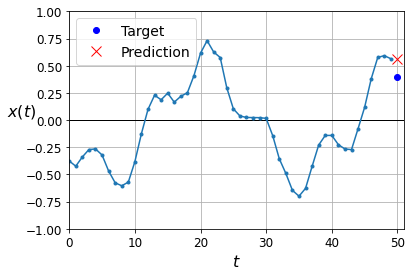

In [7]:
# 예측 모습 그래프로 시각화
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

기준 성능을 파악하는 또 다른 방법은 **완전 연결 네트워크를 사용하는 것**: 간단한 선형 회귀 모델을 사용

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0062

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086219578981

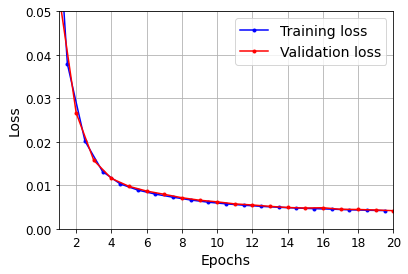

In [10]:
# 학습 곡선 그래프 작성해주는 함수
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


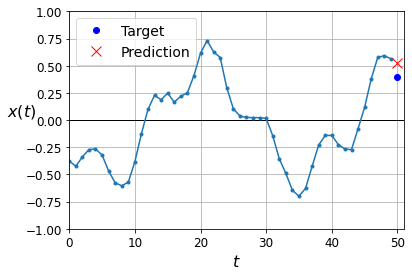

In [11]:
y_pred = model.predict(X_valid)

# 예측 모습 그래프로 시각화
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.2 간단한 RNN 구현하기

간단한 RNN을 사용해 앞서 살펴본 기준 성능을 앞지를 수 있는지 확인:

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

# 하나의 뉴런으로 이루어진 하나의 RNN 층 모델
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0116 - val_lo

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0109


0.010881561785936356

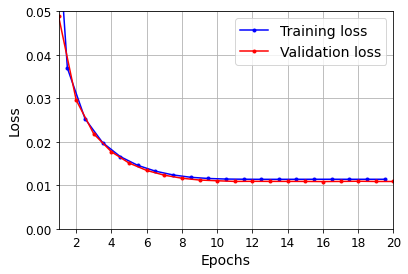

In [14]:
# 학습 곡선 확인
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 5ms/step


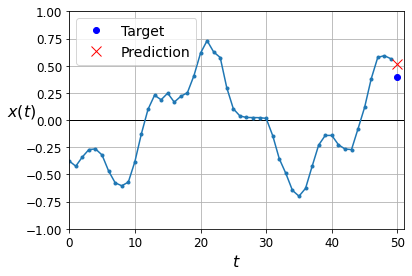

In [15]:
y_pred = model.predict(X_valid)

# 예측 모습 그래프로 시각화
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.3 심층 RNN

RNN은 아래 그림처럼 셀을 여러 층으로 쌓아 **심층 RNN(deep RNN)**으로 만드는 것이 일반적  
<img src="https://drive.google.com/uc?id=16QfNx7IFmBe88x2LwSxADzL7ppNRf8xf" height=300, width=600 >  

3개의 SimpleRNN 층을 사용하여 심층 RNN 구성:  
※ 추후에 등장할 LSTM 층이나 GRU 층 같은 다른 종류의 순환 층을 추가할 수도 있음

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 28s 118ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 26s 117ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 25s 116ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 26s 117ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 25s 116ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 25s 116ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 27s 123ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 26s 117ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 26s 117ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 25s 116ms/step - l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0029


0.0029105604626238346

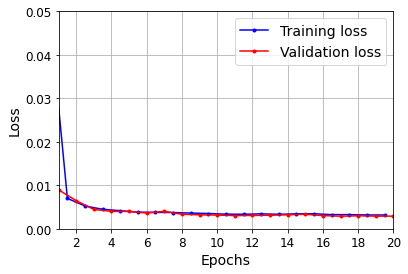

In [18]:
# 학습 곡선 확인
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 12ms/step


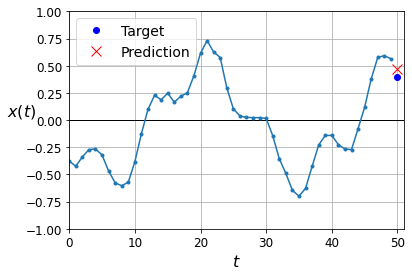

In [19]:
y_pred = model.predict(X_valid)

# 예측 모습 그래프로 시각화
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

마지막 층의 은닉 상태는 크게 필요하지 않기 때문에 출력층을 `SimpleRNN` 층이 아닌 `Dense`층으로 바꾸는 경우가 많음  
이렇게 바꾸려면 두 번째 `SimpleRNN` 층에서 `return_sequences=True`를 제거해야 함:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 19s 81ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 18s 81ms/step - loss: 0.003

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0026


0.002623624401167035

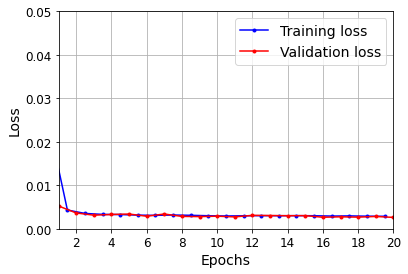

In [22]:
# 학습 곡선 확인
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 9ms/step


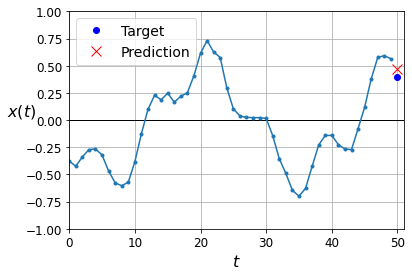

In [23]:
y_pred = model.predict(X_valid)

# 예측 모습 그래프로 시각화
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.4 여러 타임 스텝 앞을 예측하기

1. 이미 훈련된 모델을 사용하여 다음 값을 예측한 다음, 이 값을 입력으로 추가하여 여러 타임 스텝 앞을 예측하는 방법

In [24]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정하였음

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
Y_pred.shape

1/1 [==============================] - 0s 27ms/step


(1, 10, 1)

그림 저장 forecast_ahead_plot


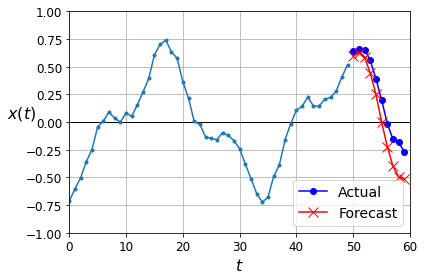

In [25]:
# 여러 타임 스텝 앞을 예측한 그래프 함수 정의
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [27]:
# 먼저 9개의 타임 스텝을 더 가진 시퀀스를 다시 생성
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [28]:
# 이제 하나씩 다음 10개의 값을 예측
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
Y_pred.shape

63/63 [==============================] - 1s 10ms/step


(2000, 10)

In [29]:
# MSE 지표 확인
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510826

In [30]:
# 위 성능을 단순한 예측이나 간단한 선형 모델과 비교
Y_naive_pred = np.tile(X_valid[:, -1], 10) # 마지막 타임 스텝 값을 선택해 10번 반복
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0227 - val_loss: 0.0222

2. RNN을 훈련하여 다음 값 10개를 한 번에 예측하는 방법

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 18s 76ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 16s 73ms/step - loss: 0.011

In [33]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 206ms/step


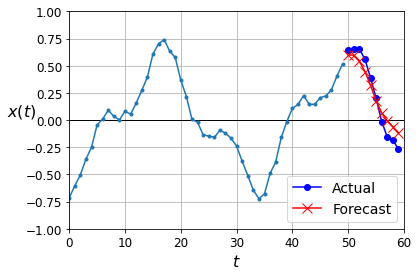

In [34]:
# 그래프로 예측 확인
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

이제 타임 스텝마다 다음 10 스텝을 예측하는 RNN을 만들어 보겠음  
즉 타임 스텝 0에서 49까지를 기반으로 타임 스텝 50에서 59를 예측하는 것이 아니라, 타임 스텝 0에서 타임 스텝 1에서 10까지 예측하고 그다음 타임 스텝 1에서 타임 스텝 2에서 11까지 예측함. 마지막 타임 스텝에서는 타임 스텝 50에서 59까지 예측함  

- 기존: 마지막 타임 스텝에서만 다음 값 10개를 예측하도록 모델을 훈련(**sequence-to-vector RNN**)  
- 지금: 모든 타임 스텝에서 다음 값 10개를 예측하도록 모델을 훈련(**sequence-to-sequence RNN**)

In [35]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10+1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True), # 마지막 층도 return_sequences=True 지정해야 함
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # 모든 타임 스텝에서 출력을 Dense 층에 적용해줌
])

# 마지막 타임 스텝의 출력에 대한 MSE만을 계산하는 지표 정의
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), 
              metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 18s 76ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0353 - val_last_time_step_mse: 0.0245
Epoch 3/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0322 - last_time_step_mse: 0.0211 - val_loss: 0.0290 - val_last_time_step_mse: 0.0168
Epoch 4/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0296 - last_time_step_mse: 0.0184 - val_loss: 0.0278 - val_last_time_step_mse: 0.0157
Epoch 5/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0275 - val_last_time_step_mse: 0.0183
Epoch 6/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0251 - last_time_step_mse: 0.0125 - val_loss: 0.0216 - val_last_time_step_mse: 0.0081
Epoch 7/20
219/2

In [38]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 209ms/step


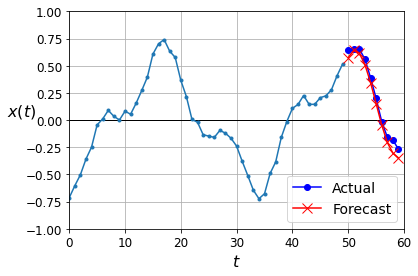

In [39]:
# 그래프로 예측 확인
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 15.4 긴 시퀀스 다루기

긴 시퀀스로 RNN을 훈련하면 많은 타임 스텝에 걸쳐 실행해야 하므로 펼친 RNN이 매우 깊은 네트워크가 됨  

그럼 아래와 같은 문제가 발생함
- 불안정한 그레이디언트 문제
- 단기 기억 문제(입력의 첫 부분을 조금씩 잊어버리는 현상)

## 15.4.1 불안정한 그레이디언트 문제와 싸우기

### 배치 정규화를 사용한 심층 RNN

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.BatchNormalization(), # 배치 정규화
    keras.layers.SimpleRNN(20, return_sequences=True), 
    keras.layers.BatchNormalization(), # 배치 정규화
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 19s 79ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/2

### 층 정규화를 사용한 심층 RNN

In [42]:
from tensorflow.keras.layers import LayerNormalization

# 각 타임 스텝마다 층 정규화를 적용하는 "사용자 정의 메모리 셀" 정의
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 43s 174ms/step - loss: 0.1592 - last_time_step_mse: 0.1551 - val_loss: 0.0735 - val_last_time_step_mse: 0.0652
Epoch 2/20
219/219 [==============================] - 37s 167ms/step - loss: 0.0643 - last_time_step_mse: 0.0548 - val_loss: 0.0567 - val_last_time_step_mse: 0.0449
Epoch 3/20
219/219 [==============================] - 37s 167ms/step - loss: 0.0530 - last_time_step_mse: 0.0411 - val_loss: 0.0494 - val_last_time_step_mse: 0.0370
Epoch 4/20
219/219 [==============================] - 36s 166ms/step - loss: 0.0471 - last_time_step_mse: 0.0352 - val_loss: 0.0450 - val_last_time_step_mse: 0.0337
Epoch 5/20
219/219 [==============================] - 36s 165ms/step - loss: 0.0431 - last_time_step_mse: 0.0316 - val_loss: 0.0411 - val_last_time_step_mse: 0.0292
Epoch 6/20
219/219 [==============================] - 36s 166ms/step - loss: 0.0397 - last_time_step_mse: 0.0287 - val_loss: 0.0376 - val_last_time_step_mse: 0.0266
Epoch 7/20

### 타임 스텝 사이에 드롭아웃을 적용하는 사용자 정의 RNN 클래스

In [44]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 39s 174ms/step - loss: 0.1579 - last_time_step_mse: 0.1531 - val_loss: 0.0719 - val_last_time_step_mse: 0.0634
Epoch 2/20
219/219 [==============================] - 38s 174ms/step - loss: 0.0627 - last_time_step_mse: 0.0506 - val_loss: 0.0555 - val_last_time_step_mse: 0.0407
Epoch 3/20
219/219 [==============================] - 38s 172ms/step - loss: 0.0520 - last_time_step_mse: 0.0387 - val_loss: 0.0506 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 38s 171ms/step - loss: 0.0458 - last_time_step_mse: 0.0312 - val_loss: 0.0431 - val_last_time_step_mse: 0.0274
Epoch 5/20
219/219 [==============================] - 37s 169ms/step - loss: 0.0427 - last_time_step_mse: 0.0271 - val_loss: 0.0403 - val_last_time_step_mse: 0.0241
Epoch 6/20
219/219 [==============================] - 38s 175ms/step - loss: 0.0387 - last_time_step_mse: 0.0229 - val_loss: 0.0368 - val_last_time_step_mse: 0.0208
Epoch 7/20

## 15.4.2 단기 기억 문제 해결하기

### LSTM 셀  
<LSTM(Long Short-Term Memory, 장단기 메모리)>  
중요한 입력을 인식하고(**입력 게이트**의 역할),  
장기 상태에 저장하고,  
필요한 기간 동안 이를 보존하고(**삭제 게이트**의 역할),  
필요할 때마다 이를 추출하기 위해 학습함  

이런 이유로 LSTM 셀은 <u>시계열, 긴 텍스트, 오디오 녹음</u> 등에서 장기 패턴을 잡아내는 데 놀라운 성과를 냄  

<img src="https://drive.google.com/uc?id=1st6P8ir4CKjhTyqpai8KaQ4amh3yuTiA" height=300, width=600>  

- 주 층은 g(t)를 출력하는 층: 현재 입력 x(t)와 이전의 (단기) 상태 h(t-1)을 분석하는 역할 담당  
- 세 개의 다른 층은 게이트 제어기
    - 삭제 게이트 f(t)는 장기 상태의 어느 부분이 삭제되어야 하는지 제어
    - 입력 게이트 i(t)는 어느 부분이 장기 상태에 더해져야 하는지 제어
    - 출력 게이트 o(t)는 장기 상태의 어느 부분을 읽어서 이 타임 스텝의 h(t), y(t)로 출력해야 하는지 제어

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 12ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

In [47]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788684979081154, 0.008560804650187492]

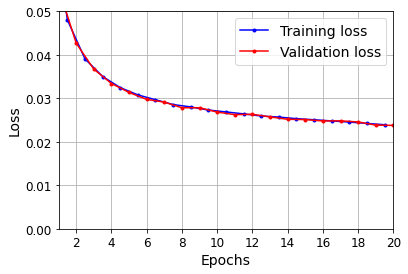

In [48]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [50]:
np.random.seed(43)

series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 619ms/step


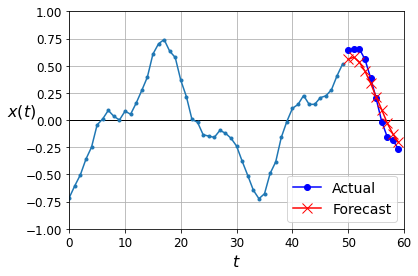

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### GRU 셀
<GRU(Gated Recurrent Unit, 게이트 순환 유닛)>  
LSTM 셀의 간소화된 버전. 간소화된 주요 내용은 다음과 같음  

<img src="https://drive.google.com/uc?id=1aWYBiq6TGA7pqSguyQKS432s73k66pSE" height=300, width=600>  
- 두 상태 벡터 h(t), c(t)가 하나의 벡터 h(t)로 합쳐졌음
- 하나의 게이트 제어기z(t)가 삭제 게이트와 입력 게이트를 모두 제어
- 출력 게이트가 없음. 즉 전체 상태 벡터가 매 타임 스텝마다 출력됨. 그러나 이전 상태의 어느 부분이 주 층 g(t)에 노출될지 제어하는 새로운 게이트 제어기 r(t)가 있음

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 11ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [======

In [53]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785501718521118, 0.010262805968523026]

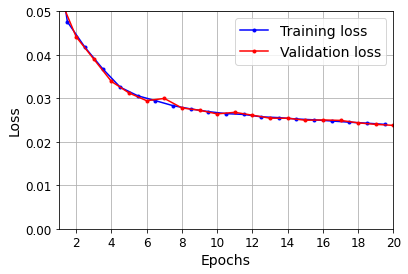

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 550ms/step


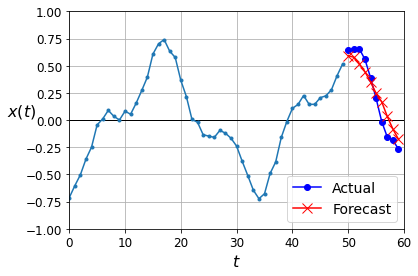

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### 1D 합성곱 층을 사용해 시퀀스 처리하기

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None,1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 9s 10ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [=======

### WAVENET  
<img src="https://drive.google.com/uc?id=1pvk7t9KTCnns-vSygq3zg1o68euZ62Ti" height=300, width=600>  

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 8ms/step - loss: 0.0668 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0323 - last_time_step_mse: 0.0193 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0245 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0240 - last_time_step_mse: 0.0117 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

다음은 논문에 정의된 원본 WaveNet임: ReLU 대신 GatedActivationUnit과 스킵 연결을 사용함  
또한 점점 더 시퀀스가 짧아지는 것을 피하기 위해 왼쪽에 0으로 패딩:

In [59]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., :n_filters])
        return self.activation(linear_output) * gate

In [60]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None,1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [62]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 3s 9ms/step - loss: 0.1302 - last_time_step_mse: 0.1262 - val_loss: 0.1233 - val_last_time_step_mse: 0.1204
Epoch 2/2
219/219 [==============================] - 2s 8ms/step - loss: 0.1224 - last_time_step_mse: 0.1180 - val_loss: 0.1218 - val_last_time_step_mse: 0.1190


# END